# Report on "Learning Fair Scoring Functions"

- Course: Statistical Theory of Algorithmic Fairness

- Authors: Alexandre Maranhão da Rocha and Ambre Adjevi-Neglokpe

This notebook aims to reproduce step by step the experiment from the paper "Learning Fair Scoring Functions: Bipartite Ranking under ROC-based Fairness Constraints" on the Adult Income dataset. 

It is fully independent (the dataset is downloaded within the notebook itself) and can be run in around 6 minutes in a regular machine.

The notebook is organized around three sections:
1. Loading Data
2. Training the Models
3. Visualizing the Results

Change this if you want to save the results (used for the report)

In [1]:
save_figures = True

We start by defining imports and some helper functions.

In [2]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

from torch import nn
import torch

from tqdm import tqdm

import matplotlib.pyplot as plt

import itertools
import random
import math

In [3]:
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
def moving_average(x, window = 1000):
    cumsum_vec = np.cumsum(np.insert(x, 0, 0)) 
    ma_vec = (cumsum_vec[window:] - cumsum_vec[:-window]) / window
    return ma_vec

set_seed(42)

## 1. Loading the Data

The Adult Income dataset can be found at https://archive.ics.uci.edu/dataset/2/adult. We first download the dataset.

In [4]:
!wget https://archive.ics.uci.edu/static/public/2/adult.zip && unzip -o adult.zip

--2024-04-08 03:11:35--  https://archive.ics.uci.edu/static/public/2/adult.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘adult.zip.9’

adult.zip.9             [               <=>  ] 605.70K   126KB/s    in 4.8s    

2024-04-08 03:11:41 (125 KB/s) - ‘adult.zip.9’ saved [620237]

Archive:  adult.zip
  inflating: Index                   
  inflating: adult.data              
  inflating: adult.names             
  inflating: adult.test              
  inflating: old.adult.names         


In [5]:
df_train = pd.read_csv("adult.data", header=None)
df_test = pd.read_csv("adult.test", header=None, comment="|")


columns = ["age", "workclass", "fnlwgt", "education", "education-num",
           "marital-status", "occupation", "relationship", "race", "sex",
           "capital-gain", "capital-loss", "hours-per-week",
           "native-country", "salary"]
col_quanti = ["age", "education-num", "capital-gain",
              "capital-loss", "hours-per-week"]  # "fnlwgt",
col_quali = ["workclass", "education", "marital-status", "occupation",
             "relationship", "race", "sex", "native-country"]

def preprocess(df, qualitative_encoder=None, scaler=None):
    df.columns = columns
    Z = df.sex.str.contains('Male').to_numpy().astype(int)
    Y = df.salary.str.contains('>50K').to_numpy().astype(int) 
    # goes from {0, 1} to {-1, 1}
    Y = 2*Y - 1
    
    X_qualitative = df[col_quali].values
    X_quantitative = df[col_quanti].values
    
    if qualitative_encoder is None:
        qualitative_encoder = OneHotEncoder(categories="auto")
        qualitative_encoder.fit(X_qualitative)
    X_qualitative_enc = qualitative_encoder.transform(X_qualitative).toarray()
    X = np.concatenate([X_qualitative_enc, X_quantitative], axis=1)
    if scaler is None:
        scaler = StandardScaler()
        scaler.fit(X)
    X = scaler.transform(X)
    
    return torch.tensor(X).float(), Y, Z, qualitative_encoder, scaler

X_train, Y_train, Z_train, qualitative_encoder, scaler = preprocess(df_train)
X_test, Y_test, Z_test, _, _ = preprocess(df_test, qualitative_encoder, scaler)

Now we have in hands our framework with $(X, Y, Z)$.

## 2. Training the Model

The model proposed by the paper is a Multilayer Perceptron (MLP) with three hidden layers and a final batch normalization. All layers have $d$ neurons, where $d$ is the dimension of the input, except for the last one, that has only one output. A Batch Normalization is applied after the last layer to normalize the scores.

In [6]:
class Model(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.fc1 = nn.Linear(n_features, n_features)
        self.fc2 = nn.Linear(n_features, n_features)
        self.fc_out = nn.Linear(n_features, 1)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm1d(1)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc_out(x)    
        x = self.bn(x)
        return x
    
    def score(self, x):
        scores = self.forward(x)
        return scores.detach().numpy().ravel()

The following functions are helpers for the training process.

`incomplete_auc` will estimate the AUC using incomplete U-statistics by averaging a random sample of $B$ pairs

$$ AUC^{(B)}_{H_s, G_s} = \frac{1}{B} \sum_{i<j} \sigma[(s(x_i) s(x_j))(y_i - y_j)]$$

In [7]:
def incomplete_auc(sc, y, B=100):
    rel = nn.Sigmoid()
    
    p_sc, p_y = sc[y == 1], y[y == 1]
    n_sc, n_y = sc[y != 1], y[y != 1]

    num_n = n_y.size(0)
    num_p = p_y.size(0)

    if num_n == 0 or num_p == 0:
        return torch.tensor([0], dtype=float, requires_grad=True), torch.tensor([0],  dtype=float, requires_grad=True)

    # Samples D_B
    n_ind = torch.randint(0, num_n, (B,))
    p_ind = torch.randint(0, num_p, (B,))

    # Takes (s(xi) - s(xj))(1 - (-1))
    prod = 2 * (p_sc[p_ind] - n_sc[n_ind])
    rel_auc = torch.mean(rel(-prod))
    auc = (torch.mean((prod < 0).float()) + 0.5 * torch.mean((prod == 0).float()))
    return rel_auc, auc

`gen_batch` will implement 

$$\mathcal{B}_N \leftarrow \text{N observations sampled with replacement from } \mathcal{D}_n$$

In [8]:
def gen_batch(X, y, z, n_batch):
    selected = np.random.randint(0, len(y), n_batch)   
    y_batch = torch.tensor(y[selected])
    z_batch = torch.tensor(z[selected])
    return X[selected], y_batch, z_batch

The AUC Loss is

$$ L^{(B)}_{\lambda, c}(s) = (1-{\text{AUC}}^{(B)}_{H_s, G_s}) + \lambda \cdot c \cdot (AUC^{(B)}_{H_s^{(1)}, G_s^{(1)}}  - AUC^{(B)}_{H_s^{(0)}, G_s^{(0)}} )$$

And the adaptive update is 

$$ \Delta {AUC} \leftarrow AUC^{(B_V)}_{H_s^{(1)}, G_s^{(1)}} - AUC^{(B_V)}_{H_s^{(0)}, G_s^{(0)}}$$
$$ c \leftarrow \min(1, \max(-1, c + sign(\Delta AUC)\cdot \Delta c)$$

In [9]:
class AUCLoss():
    def __init__(self, lambd, adapt_step):
        self.c = 0
        self.lambd = lambd
        self.adapt_step = adapt_step

    def _compute(self, score, y, z, B):
        rel_auc, auc = incomplete_auc(score, y, B)
        
        # Distinguish between positive man and negative women
        filter1 = ((z==1) & (y==1)) | ((z==0) & (y==-1))
        label1 = ((z==1) & (y==1)).int()
        # Distinguish between positive women and negative man
        filter2 = ((z==1) & (y==-1)) | ((z==0) & (y==1))
        label2 = ((z==0) & (y==1)).int()

        rel_auc_0, auc_0 = incomplete_auc(score[filter1], label1[filter1], B)
        rel_auc_1, auc_1 = incomplete_auc(score[filter2], label2[filter2], B)

        rel_fair_auc = rel_auc_0 - rel_auc_1
        fair_auc = auc_0 - auc_1

        rel_cost = rel_auc + self.lambd*self.c*rel_fair_auc

        return rel_cost, fair_auc
        
    def compute_loss(self, score, y, z, B=100):
        rel_cost, fair_auc = self._compute(score, y, z, B)
        return rel_cost
    
    def adaptive_step(self, score_val, X_val, y_val, z_val):
        val_cost, val_fair_auc = self._compute(score_val, torch.tensor(y_val), torch.tensor(z_val), B=100000)
        self.c = float(min(1, max(-1, self.c + np.sign(val_fair_auc.detach().numpy())*self.adapt_step)))

The ROC Constraints are of the form $|\Delta F_{k, \alpha^{(k)}}| = 0$, where $k \in \{1, ..., K\}$ and each $F_k$ is fixed to be either $G$ or $H$. 

The loss to enforce this constraint is

<!-- $$ \hat{L}_{\Lambda,c,t}(s) := (1 - {AUC}_{H_s,G_s}) + \frac{1}{m_H} \sum_{k=1}^{m_H} \lambda^{(k)}_H \cdot \ell^{(k)}_H (s) + \frac{1}{m_G} \sum_{k=1}^{m_G} \lambda^{(k)}_G \cdot \ell^{(k)}_G (s)$$ -->


$$ \hat{L}_{\Lambda,c,t}(s) := (1 - {AUC}_{H_s,G_s}) + \frac{1}{K} \sum_{k=1}^{K} \lambda^{(k)}_F \cdot c^{(k)} \cdot \left( \hat{F}^{(0)}_s \left( t^{(k)} \right) - \hat{F}^{(1)}_s \left( t^{(k)} \right) \right) $$

Where

$$ \hat{H}^{(z)}_s (t) = \frac{1}{N^{(z)}} \sum_{i=1}^{N} \mathbb{I}\{y_i = -1, z_i = z\} \cdot \sigma(t - s(x_i)) $$

$$ \hat{G}^{(z)}_s (t) = \frac{1}{N_{+}^{(z)}} \sum_{i=1}^{N} \mathbb{I}\{y_i = +1, z_i = z\} \cdot \sigma(t - s(x_i)) $$

<!-- $$ \ell^{(k)}_F (s) = c^{(k)}_F \cdot \left( \hat{F}^{(0)}_s \left( t^{(k)}_F \right) - \hat{F}^{(1)}_s \left( t^{(k)}_F \right) \right) $$ -->

Both $c^{(k)}$ and $t^{(k)}$ are adaptive parameters that will start as 0 and be updated as the training goes.

We ommit the equations of the adaptive update for brevity, but they update either $t^{(k)}$ or $c^{(k)}$ according to a condition, and the update has steps $\Delta t$ that we call `adapt_step_t` and $\Delta c$ that we call `adapt_step_c`.

In [10]:
class ROCLoss():
    def __init__(self, lambd, adapt_step_c, adapt_step_t, points=None):
        self.adapt_step_c = adapt_step_c
        self.adapt_step_t = adapt_step_t
        if points is None:
            points = {-1: [0.125, 0.25]}
        self.points = points
        self.alphas = np.array(list(itertools.chain.from_iterable(self.points.values())))
        self.n_c = sum(len(x) for x in points.values())        
        self.c = [0] * self.n_c
        self.lambdas = [lambd] * self.n_c
        self.thresholds = np.array([float(v) for v in self.c])

        
    def _compute(self, score, y, z, B=100):
        rel = nn.Sigmoid()
        
        rel_pointwise_val = [ ]
        pointwise_val = [ ]
        fprs = [ ]
        tprs = [ ]
        
        pt_ix = 0
        for y_v, points in self.points.items():
            z_sel = z[y == y_v]
            scores_sel = score[y == y_v]
            for pt in points:
                biased_sc = scores_sel - self.thresholds[pt_ix]
                rel_biased_sc = rel(biased_sc)
                
                n_z_1 = (z == 1).sum()
                no_z_1 = n_z_1 == 0
                no_z_0 = ((z == 1).shape[0] - n_z_1 == 0)
                
                rel_tpr = torch.mean(rel_biased_sc[z_sel==1]) if not no_z_1.item() else torch.tensor(0.)
                rel_fpr = torch.mean(rel_biased_sc[z_sel==0]) if not no_z_0.item() else torch.tensor(0.)

                tpr = (biased_sc[z_sel==1] > 0).float() if not no_z_1.item() else torch.tensor(0.)
                fpr = (biased_sc[z_sel==0] > 0).float() if not no_z_0.item() else torch.tensor(0.)

                rel_cost = self.c[pt_ix]*(rel_fpr - rel_tpr)
                cost = self.c[pt_ix]*(fpr.mean() - tpr.mean())

                rel_pointwise_val.append(rel_cost)
                pointwise_val.append(cost)
                tprs.append(tpr.mean())
                fprs.append(fpr.mean())
                
                pt_ix += 1
                
        rel_cost, _ = incomplete_auc(score, y, B)
        for i in range(self.n_c):
            if self.lambdas[i] > 0:
                rel_cost += self.lambdas[i]*rel_pointwise_val[i]
                
        return rel_cost, np.array(fprs), np.array(tprs)
    
    def compute_loss(self, score, y, z, B=100):
        rel_cost, _, _ = self._compute(score, y, z, B=100)
        return rel_cost
        
    def adaptive_step(self, score_val, X_val, y_val, z_val):
        cost, fprs, tprs = self._compute(score_val, torch.tensor(y_val), torch.tensor(z_val), B=100000)
        devs = (fprs - tprs)/2
        means = (fprs + tprs)/2
        for i in range(self.n_c):
            if np.abs(means[i] - self.alphas[i]) > np.abs(devs[i]):
                if means[i] > self.alphas[i]:
                    self.thresholds[i] = self.thresholds[i] + self.adapt_step_t
                else:
                    self.thresholds[i] = self.thresholds[i] - self.adapt_step_t
            else:
                if devs[i] > 0:
                    self.c[i] = min(self.c[i] + self.adapt_step_c, 1)
                else:
                    self.c[i] = max(self.c[i] - self.adapt_step_c, -1)

The training process will call the loss calculator `compute_loss` function and run an Adam optimizer to minimize it. The main hyperparameters are

- Learning rate `lr`
- Regularization coefficient `coef_regularization`
- Number of epochs `n_epochs`
- Number of epochs until an adaptive step `n_adaptive`
- Batch size `batch_size`

In [11]:
def train_model(loss_calculator, lr=1e-3, coef_regularization=0.05, n_epochs=20000, batch_size = 100, n_adaptive = 50):    
    model = Model(n_features=X_train.shape[1])
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # further split training data into proper training _tr and validation _val
    X_tr, X_val, y_tr, y_val, z_tr, z_val = train_test_split(X_train, Y_train, Z_train, test_size=0.4, random_state=42)

    history = []
    for step in tqdm(range(n_epochs)):
        X_batch, y_batch, z_batch = gen_batch(X_tr, y_tr, z_tr, n_batch=batch_size)
        score_batch = model(X_batch)
        loss = loss_calculator.compute_loss(score_batch, y_batch, z_batch, B=batch_size)
        
        for param in model.parameters():
            loss += coef_regularization * param.norm(2)**2

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()  
        history.append(loss.item())

        if (step == n_epochs - 1) or (step % n_adaptive == 0):
            with torch.no_grad():
                score_val = model(X_val)
            loss_calculator.adaptive_step(score_val, X_val, y_val, z_val)

    return model, history

We are going to train threee different models:

1. No constraint
2. AUC contraint
3. ROC constraint

100%|██████████| 20000/20000 [02:01<00:00, 164.48it/s]


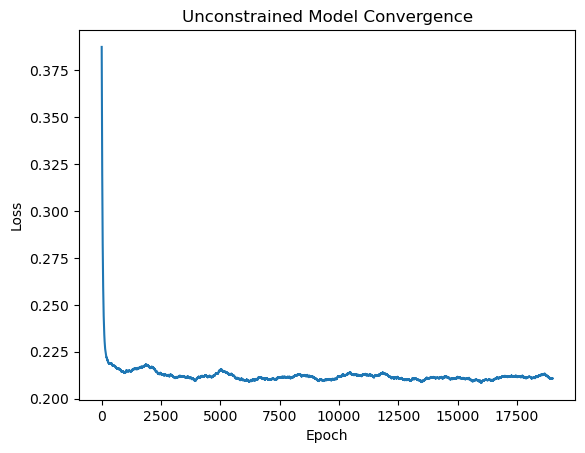

In [12]:
unconstrained_loss = AUCLoss(lambd=0, adapt_step=0)
model_noconstraint, history = train_model(
    loss_calculator=unconstrained_loss, 
    lr=1e-3, 
    coef_regularization=0.05,
    n_epochs=20000
)

plt.plot(moving_average(history))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Unconstrained Model Convergence')
plt.show()

100%|██████████| 20000/20000 [01:57<00:00, 170.00it/s]


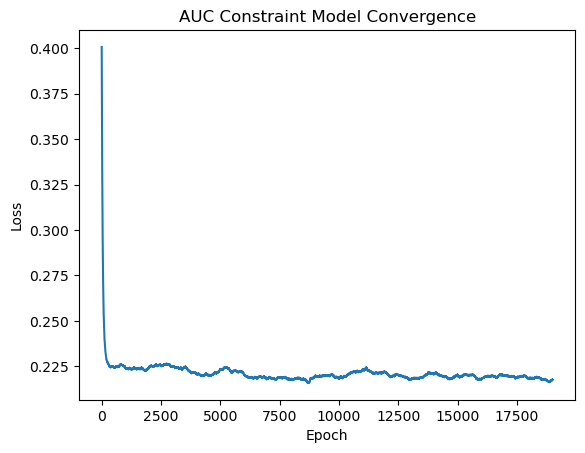

In [13]:
aucloss = AUCLoss(lambd=0.25, adapt_step=0.01)
model_auc, history = train_model(
    loss_calculator=aucloss,
    lr=1e-3, 
    coef_regularization=0.05,
    n_epochs=20000
)

plt.plot(moving_average(history))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('AUC Constraint Model Convergence')
plt.show()

100%|██████████| 20000/20000 [01:50<00:00, 181.56it/s]


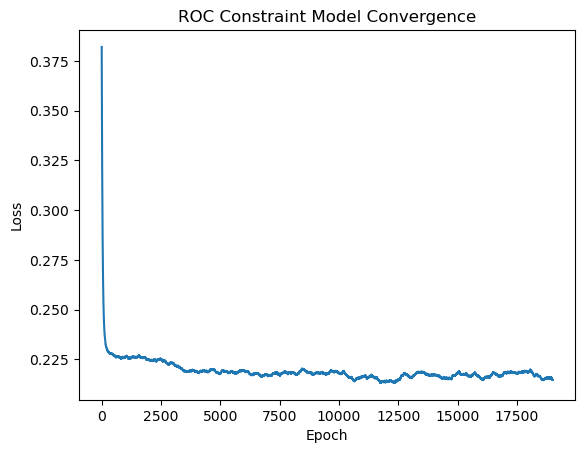

In [14]:
rocloss = ROCLoss(lambd=0.25, adapt_step_t=0.001, adapt_step_c=0.01)
model_roc, history = train_model(
    loss_calculator=rocloss, 
    lr=1e-3, 
    coef_regularization=0.05,
    n_epochs=20000
)

plt.plot(moving_average(history))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ROC Constraint Model Convergence')
plt.show()

All three models were trained to convergence without any issues.

## 3. Evaluation

<!-- First, we use the trained model to calculate the scores in the test set. Then, we can calculate the False Positive and True Positive rates to plot the ROC curves.  -->

Again, we start by defining some helper functions.

`fpr_tpr` calculates the False Positive and True Positive rates between an array of scores and one of classes.

In [15]:
def fpr_tpr(scores, classes):
    scores = np.array(scores)
    classes = (np.array(classes) == +1).astype(int)

    n_pos = classes.sum()
    n_neg = classes.shape[0] - n_pos

    # indices of scores in increasing order
    ind_sort = np.argsort(scores)
    # if the scoring is perfect, all 0 would come before all 1s
    cl_sort = classes[ind_sort]
    
    # False Negative Rate (FN/(TP+FN))
    # False Negatives are all 1s that came before the threshold
    # TP+FN are all samples that have a positive real label
    fnr = cl_sort.cumsum()/n_pos
    # True Positive Rate (TP/(TP+FN))
    tpr = 1 - fnr
    # True Negative Rate (TN/(FP+TN))
    # True Negatives are all 0s that came before the threshold
    # FP+TN are all samples that have a negative real label
    tnr = (1-cl_sort).cumsum()/n_neg
    # False Positive Rate (FP/(FP+TN))
    fpr = 1 - tnr

    return fpr, tpr

`auc` calculates the true AUC between an array of scores and one of classes. The way it does it is the following. The AUC can be interpreted as the probability that a randomly chosen positive instance is ranked higher than a randomly chosen negative instance, or

$$ AUC := P(\Delta s_{ij} > 0) + \frac{1}{2}P(\Delta s_{ij} = 0)$$

We then take all the pairs $(i, j)$ where $y_i = 1$ and $y_j = 0$, calculate $\Delta s_ij$ and then apply the above formula replacing probabilities by means.

In [16]:
def auc(scores, y):
    s = scores.reshape((-1, 1))
    y = y.reshape((-1, 1))
    # all pairwise differences
    diff = y - y.T
    # pairs (i, j)
    pair_i, pair_j = np.where(diff > 0)
    # score difference for these pairs
    delta_s = s[pair_i] - s[pair_j]
    auc_value = (delta_s > 0).mean() + 0.5*(delta_s == 0).mean()
    return auc_value

`pointwise_tpr` calculates $ROC_{G_s^{(0)}, G_s^{(1)}}(\alpha)$. In other words, it gives the percentage of the samples of a group that were scored above the top $\alpha$% of the other group. Ideally, if the groups are completely equal, this will be an identity line, that is, $ROC_{G_s^{(0)}, G_s^{(1)}}(\alpha) = \alpha$. The violation is called $\Delta ROC_{G_s^{(0)}, G_s^{(1)}}(\alpha)$.

In [17]:
def pointwise_tpr(scores, groups, alpha):
    sorted_neg_scores = np.sort(scores[groups == 0])
    n_neg = (groups == 0).sum()
    threshold = sorted_neg_scores[math.floor(n_neg*(1-alpha))]
    return (scores[groups==1] > threshold).mean()

`plot_evaluation` will plot the ROC curves of interest as in the paper.

In [18]:
def plot_evaluation(s_test, Y_test, Z_test):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    s_1 = "$ROC_{H_s^{(1)}, G_s^{(0)}}$"
    s_2 = "$ROC_{H_s^{(0)}, G_s^{(1)}}$"

    # Distinguish between positive man and negative women
    filt = ((Z_test==1) & (Y_test==1)) | ((Z_test==0) & (Y_test==-1))
    label = ((Z_test==1) & (Y_test==1))
    fpr_1, tpr_1 = fpr_tpr(s_test[filt], label[filt])
    
    # Distinguish between positive women and negative man
    filt = ((Z_test==1) & (Y_test==-1)) | ((Z_test==0) & (Y_test==1))
    label = ((Z_test==0) & (Y_test==1))
    fpr_2, tpr_2 = fpr_tpr(s_test[filt], label[filt])
    
    fpr, tpr = fpr_tpr(s_test, Y_test)

    axs[0].plot(fpr_1, tpr_1, label=s_1, color="green", linestyle='-')
    axs[0].plot(fpr_2, tpr_2, label=s_2, color="blue", linestyle='-')
    axs[0].plot(fpr, tpr, label="$ROC_{H_s, G_s}$", color="black", linestyle='-')

    s_1, s_2 = "$ROC_{H_s^{(0)}, H_s^{(1)}}$", "$ROC_{G_s^{(0)}, G_s^{(1)}}$"

    fpr_1, tpr_1 = fpr_tpr(s_test[Y_test!=1], Z_test[Y_test!=1])
    fpr_2, tpr_2 = fpr_tpr(s_test[Y_test==1], Z_test[Y_test==1])
    fpr, tpr = fpr_tpr(s_test, Y_test)

    axs[1].plot([0, 1], [0, 1], color="grey")
    axs[1].plot(fpr_1, tpr_1, label=s_1, color="orange", linestyle='-')
    axs[1].plot(fpr_2, tpr_2, label=s_2, color="indigo", linestyle='-')

    for ax in axs:
        ax.set_xlabel("$FPR$")
        ax.set_ylabel("$TPR$")
        ax.set_xticks(np.arange(0, 1, step=0.25))  
        ax.grid()
        ax.legend()


Finally, function `evaluate` will take a model and:

1. Calculate the scores based on this model
2. Print relevant metrics
3. Plot the ROC curves

In [19]:
def evaluate(model, title, save=False):
    scores = model.score(X_test)
    auc_val = auc(scores, Y_test)
    
    # Distinguish between positive man and negative women
    filtr = ((Z_test==1) & (Y_test==1)) | ((Z_test==0) & (Y_test==-1))
    label = ((Z_test==1) & (Y_test==1)).astype(int)
    auc_0 = auc(scores[filtr], label[filtr])
    
    # Distinguish between positive women and negative man
    filtr = ((Z_test==1) & (Y_test==-1)) | ((Z_test==0) & (Y_test==1))
    label = ((Z_test==0) & (Y_test==1)).astype(int)
    auc_1 = auc(scores[filtr], label[filtr])

    delta_auc = np.abs(auc_0 - auc_1)
    
    h_14 = pointwise_tpr(scores[Y_test==-1], Z_test[Y_test==-1], 1/4)
    h_18 = pointwise_tpr(scores[Y_test==-1], Z_test[Y_test==-1], 1/8)
    delta_h_14 = np.abs(h_14 - 1/4)
    delta_h_18 = np.abs(h_18 - 1/8)
    
    g_14 = pointwise_tpr(scores[Y_test==1], Z_test[Y_test==1], 1/4)
    g_18 = pointwise_tpr(scores[Y_test==1], Z_test[Y_test==1], 1/8)
    delta_g_14 = np.abs(g_14 - 1/4)
    delta_g_18 = np.abs(g_18 - 1/8)
    
    print(f'AUC: {auc_val:.2f}')
    print(f'Delta AUC: {delta_auc:.3f}')
    print(f'Delta H 1/8: {delta_h_18:.2f}')
    print(f'Delta H 1/4: {delta_h_14:.2f}')
    print(f'Delta G 1/8: {delta_g_18:.2f}')
    print(f'Delta G 1/4: {delta_g_14:.2f}')
    
    plot_evaluation(scores, Y_test, Z_test)
    plt.suptitle(title)
    if save:
        filename = title.replace(" ", "_").lower()
        plt.savefig(f'{filename}.eps', format='eps')  
    plt.show()

We will run it for the three models previously defined.

AUC: 0.90
Delta AUC: 0.181
Delta H 1/8: 0.29
Delta H 1/4: 0.35
Delta G 1/8: 0.12
Delta G 1/4: 0.15


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


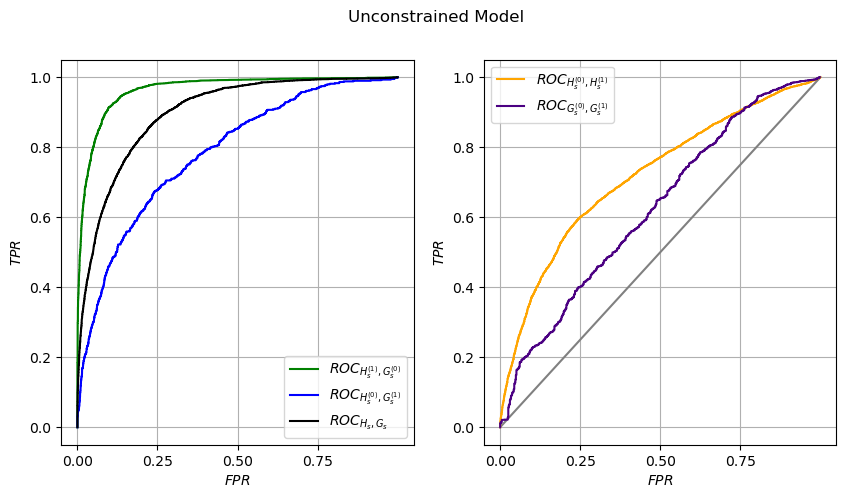

In [20]:
evaluate(model_noconstraint, 'Unconstrained Model', save=save_figures)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


AUC: 0.89
Delta AUC: 0.003
Delta H 1/8: 0.06
Delta H 1/4: 0.11
Delta G 1/8: 0.07
Delta G 1/4: 0.16


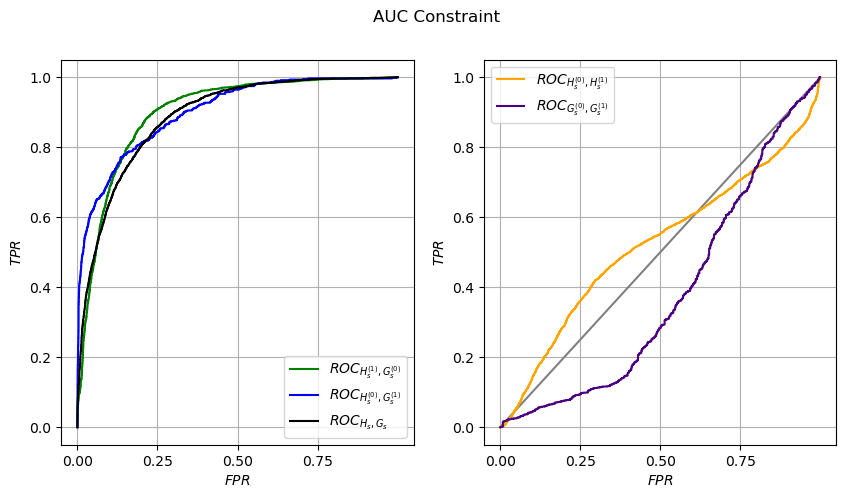

In [21]:
evaluate(model_auc, 'AUC Constraint', save=save_figures)

The AUC Constraint is able to reduce the AUC violation to a negligible value, but there are huge differences in the ROC curve in the right.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


AUC: 0.87
Delta AUC: 0.059
Delta H 1/8: 0.06
Delta H 1/4: 0.03
Delta G 1/8: 0.02
Delta G 1/4: 0.01


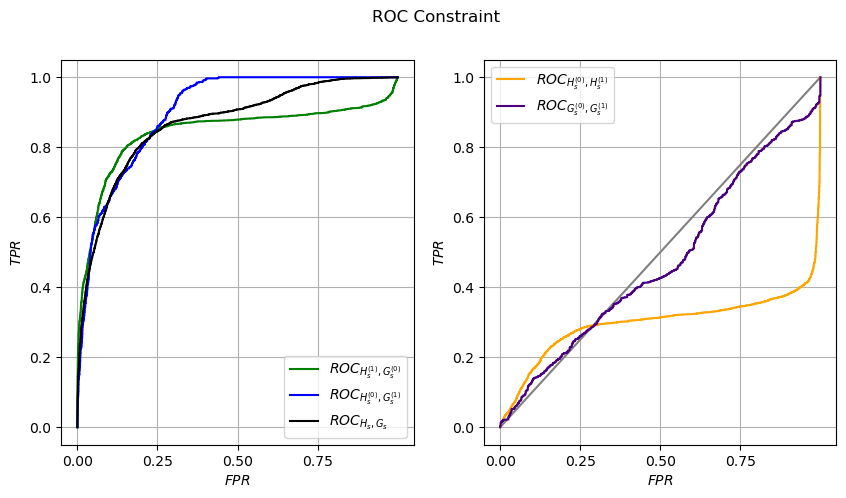

In [22]:
evaluate(model_roc, 'ROC Constraint', save=save_figures)

Finally, the ROC Constraint does not have the same impact on AUC, but reduces the differences in the ROC curve on the right exactly on the region of interest for applications [0, 1/4].